# Preliminar section

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table as Tb
from astropy.io import fits
from scipy.constants import c
from tqdm import tqdm
from scipy.ndimage import gaussian_filter

In [4]:
qsolist = fits.open('MAGG_spectra_merged.fits')
print (qsolist.info())

Filename: MAGG_spectra_merged.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  J010619.24+004823.3    1 BinTableHDU     17   26072R x 3C   [D, D, D]   
  2  J012403.77+004432.7    1 BinTableHDU     17   25429R x 3C   [D, D, D]   
  3  J013340.31+040059.7    1 BinTableHDU     17   25429R x 3C   [D, D, D]   
  4  J013724.36-422417.3    1 BinTableHDU     17   25430R x 3C   [D, D, D]   
  5  J015741.56-010629.6    1 BinTableHDU     17   28401R x 3C   [D, D, D]   
  6  J020944.61+051713.6    1 BinTableHDU     17   28402R x 3C   [D, D, D]   
  7  J024401.84-013403.7    1 BinTableHDU     17   25429R x 3C   [D, D, D]   
  8  J033413.42-161205.4    1 BinTableHDU     17   26713R x 3C   [D, D, D]   
  9  J033900.98-013317.7    1 BinTableHDU     17   26662R x 3C   [D, D, D]   
 10  J094932.26+033531.7    1 BinTableHDU     17   26719R x 3C   [D, D, D]   
 11  J095852.19+120245.0    1 BinTableHDU     17   26139R x 3C   [D, D, 

In [17]:
laes = Tb.read('MAGG_LAEs.fits')
print (laes.colnames)

['FIELD', 'z', 'z_corr', 'RA_deg', 'DEC_deg', 'R_kpc', 'Lum', 'LumErr']


In [18]:
print (laes)

       FIELD              z       ...         LumErr        
------------------- ------------- ... ----------------------
J010619.24+004823.3      2.926344 ...  7.945311826009941e+40
J010619.24+004823.3 3.10823812893 ... 1.0097005994398644e+41
J010619.24+004823.3 3.12134996922 ...  9.639746500686158e+40
J010619.24+004823.3 3.20808559003 ...  8.957599905770926e+40
J010619.24+004823.3    3.21117682 ... 1.5087090345596136e+41
J010619.24+004823.3        3.2247 ...  1.569898366629773e+41
J010619.24+004823.3       3.27537 ... 1.6622059749643417e+41
J010619.24+004823.3        3.3267 ...  1.772353031854091e+41
J010619.24+004823.3       3.32725 ... 2.8259290851745787e+41
J010619.24+004823.3        3.3276 ... 1.6414110933974275e+41
                ...           ... ...                    ...
J234913.75-371259.2      4.303664 ... 2.3417530430861282e+41
J234913.75-371259.2 4.38423212931 ... 2.2509935766450925e+41
J234913.75-371259.2     4.3840295 ... 1.9886266061028305e+41
J234913.75-371259.2     

In [107]:
r_bin = np.linspace (0, 250, 25)
v_bin = np.linspace (-10000, 10000, 25)

tau_matrix = np.zeros((len(r_bin)-1, len(v_bin)-1)) #x axes: v, y axes: r
counting_matrix = np.zeros((len(r_bin)-1, len(v_bin)-1))

In [108]:
for i in tqdm (range (1, len(qsolist))):
    qso_table = Tb.read(qsolist[i])
    wave = qso_table['wave']
    redshift = wave / 1215.67 - 1
    flux = qso_table['flux']
    flux_corr = np.clip(flux, 10**(-5), None)
    tau = -np.log(flux_corr)
    err = qso_table['err']
    name_qso = qsolist[i].name
    z_qso = qsolist[i].header['z_QSO']
    field = laes[(laes['FIELD'] == name_qso) & (laes['z_corr'] < z_qso) & (laes['z_corr'] > 2.8)] #field on which we are operating (i.e. matching the FIELD name)
    for lae in field:
        lae_z = lae['z_corr']
        lae_wave_meas = 1215.67 * (1 + lae_z) #10^-10 m #measured wavelength of the Lyman-alpha line
        deltav = 3*10**5 * (redshift - lae_z) / (1 + lae_z) #km/s
        # delta_lambda = deltav/c * 1215.67 #10^10 m
        lae_r = lae['R_kpc']
        
        for v_val, tau_val in zip (deltav, tau):
            i_r = np.digitize (lae_r, r_bin) - 1
            i_v = np.digitize (v_val, v_bin) - 1
            if 0 <= i_r < len(r_bin)-1 and 0 <= i_v < len(v_bin)-1:
                if np.isfinite(tau_val):
                    tau_matrix[i_r][i_v] += tau_val
                    counting_matrix[i_r][i_v] += 1
                

100%|██████████| 28/28 [00:34<00:00,  1.22s/it]


In [113]:
print (counting_matrix)

[[  57.   57.   57.   57.   56.   58.   56.   57.   57.   57.   57.   57.
    57.   57.   57.   57.   57.   57.   57.   57.   57.   57.   57.   57.]
 [ 121.  139.  156.  155.  155.  154.  154.  153.  153.  152.  152.  152.
   151.  151.  150.  150.  150.  149.  149.  148.  148.  148.  147.  146.]
 [ 307.  308.  308.  340.  343.  342.  341.  342.  340.  341.  339.  342.
   341.  339.  339.  339.  338.  339.  337.  338.  336.  338.  336.  339.]
 [ 299.  297.  299.  293.  290.  294.  309.  327.  325.  325.  325.  324.
   323.  323.  323.  322.  320.  322.  320.  322.  321.  317.  321.  318.]
 [ 261.  259.  260.  259.  259.  258.  257.  255.  258.  254.  256.  255.
   277.  288.  286.  286.  285.  285.  284.  283.  283.  283.  281.  280.]
 [  79.   78.   77.   78.   77.   77.   77.   77.   76.   76.   76.   76.
    76.   75.   75.   75.   75.   75.   74.   74.   74.   74.   74.   73.]
 [ 450.  459.  478.  473.  465.  480.  505.  509.  545.  548.  546.  546.
   544.  539.  540.  539.  543. 

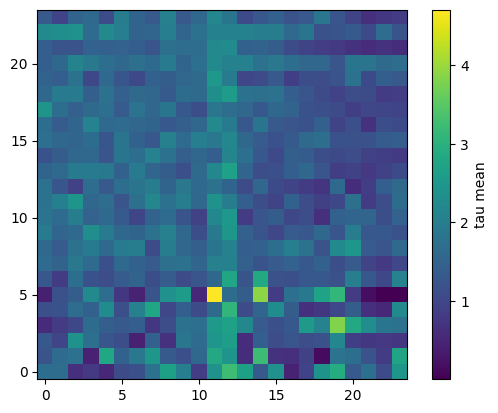

In [109]:
plt.imshow (tau_matrix/counting_matrix, origin='lower')
plt.colorbar(label='tau mean')
plt.show()

In [110]:
tau_map = gaussian_filter(tau_matrix/counting_matrix, sigma=1.5)

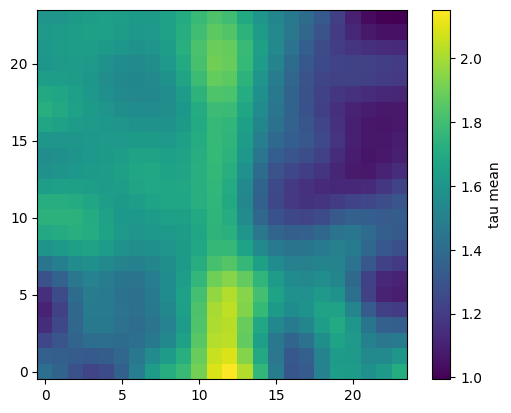

In [111]:
plt.imshow(tau_map, origin='lower')
plt.colorbar(label='tau mean')
plt.show()

In [112]:
print (tau_matrix) 

[[9.70650368e+01 9.63962669e+01 3.63776028e+01 4.49276537e+01
  2.96154295e+01 6.37203781e+01 6.43626470e+01 9.99140704e+01
  1.52652012e+02 1.15387863e+02 4.92643283e+01 1.36278265e+02
  1.84688376e+02 1.52328815e+02 7.52215669e+01 1.36236733e+02
  2.64581668e+01 5.44731984e+01 1.36928294e+02 1.66430844e+02
  7.66029548e+01 9.82137131e+01 6.26540324e+01 1.41889842e+02]
 [1.45439030e+02 2.29370919e+02 2.76599050e+02 6.73295342e+01
  4.33796712e+02 2.25914806e+02 2.89583478e+02 3.81802396e+02
  2.03460134e+02 1.74643399e+02 2.38084154e+02 4.31805608e+02
  3.68851905e+02 9.39306439e+01 4.83995966e+02 1.03685576e+02
  9.79182762e+01 1.37482489e+02 2.06855698e+01 2.65053466e+02
  2.53381422e+02 1.77480987e+02 1.24371642e+02 4.03105090e+02]
 [3.98168495e+02 3.01514303e+02 7.39616988e+02 5.90938154e+02
  4.35477037e+02 3.88927988e+02 1.46626685e+02 4.93948543e+02
  2.26675458e+02 6.29553750e+02 5.56121358e+02 8.38445716e+02
  8.93576611e+02 2.01675499e+02 4.76206659e+02 3.78999990e+02
  4.21

In [ ]:
'''
mask = (wave > (lae_wave_meas - delta_lambda)) & (wave < (lae_wave_meas + delta_lambda))

        flux_region = flux[mask]
        wave_region = wave[mask]


        r_sx_extr = np.where (r_bin < lae_r)[0][0]

        for j in range (len(deltav)) :
            v_sx_extr = np.where (v_bin < deltav[j])[0][0]

            tau_matrix [r_sx_extr, v_sx_extr] += np.nan_to_num(tau[j])
            counting_matrix [r_sx_extr, v_sx_extr] += 1
'''

'\nmask = (wave > (lae_wave_meas - delta_lambda)) & (wave < (lae_wave_meas + delta_lambda))\n\n        flux_region = flux[mask]\n        wave_region = wave[mask]\n'